In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense,SimpleRNN
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
plt.rcParams['figure.figsize'] = [15,8]

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Thesis datasets/Alcohol_Sales_Data.csv')
df.head()

,DATE,Millions of Dollars
0,1992-01-01,3459
1,1992-02-01,3458
2,1992-03-01,4002
3,1992-04-01,4564
4,1992-05-01,4221


In [5]:
df.tail()

,DATE,Millions of Dollars
352,2021-05-01,15499
353,2021-06-01,17830
354,2021-07-01,15742
355,2021-08-01,16142
356,2021-09-01,15772


In [6]:
df.shape

(357, 2)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   DATE                 357 non-null    object
 1   Millions of Dollars  357 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.7+ KB


In [8]:
df.isnull().sum()

DATE                   0
Millions of Dollars    0
dtype: int64

In [9]:
time = pd.date_range(start='1/1/1992',end='09/30/2021',freq='M')
time

DatetimeIndex(['1992-01-31', '1992-02-29', '1992-03-31', '1992-04-30',
               '1992-05-31', '1992-06-30', '1992-07-31', '1992-08-31',
               '1992-09-30', '1992-10-31',
               ...
               '2020-12-31', '2021-01-31', '2021-02-28', '2021-03-31',
               '2021-04-30', '2021-05-31', '2021-06-30', '2021-07-31',
               '2021-08-31', '2021-09-30'],
              dtype='datetime64[ns]', length=357, freq='M')

In [10]:
len(time)

357

In [11]:
df['time_stamp'] = pd.DataFrame(time)

In [12]:
df.head()

,DATE,Millions of Dollars,time_stamp
0,1992-01-01,3459,1992-01-31
1,1992-02-01,3458,1992-02-29
2,1992-03-01,4002,1992-03-31
3,1992-04-01,4564,1992-04-30
4,1992-05-01,4221,1992-05-31


In [13]:
df.tail()

,DATE,Millions of Dollars,time_stamp
352,2021-05-01,15499,2021-05-31
353,2021-06-01,17830,2021-06-30
354,2021-07-01,15742,2021-07-31
355,2021-08-01,16142,2021-08-31
356,2021-09-01,15772,2021-09-30


In [14]:
df.drop('DATE',axis=1,inplace=True)
df = df.set_index('time_stamp')

In [18]:
df.columns = ['Millions_of_Dollars']

In [19]:
df.head()

,Millions_of_Dollars
time_stamp,
1992-01-31,3459
1992-02-29,3458
1992-03-31,4002
1992-04-30,4564
1992-05-31,4221


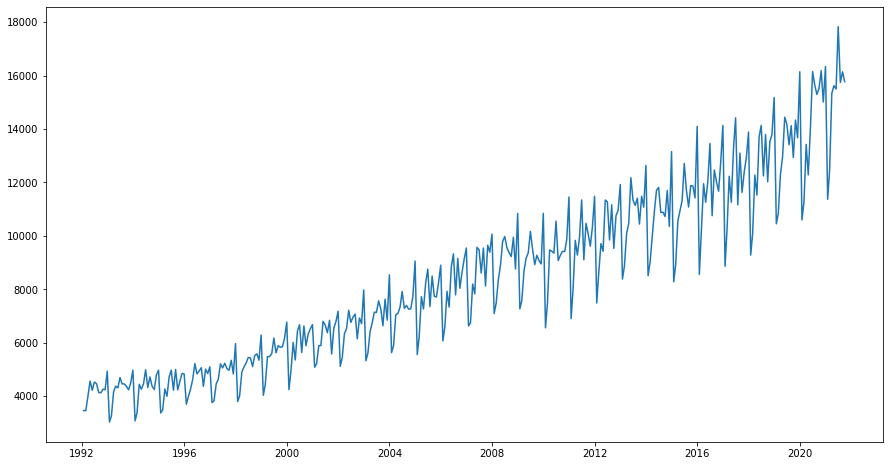

In [20]:
plt.plot(df)
plt.show()

In [17]:
def convert2matrix(data_arr, look_back):
    X, Y =[], []
    for i in range(len(data_arr)-look_back):
        d=i+look_back  
        X.append(data_arr[i:d,])
        Y.append(data_arr[d,])
    return np.array(X), np.array(Y)

In [112]:
from sklearn.preprocessing import MinMaxScaler
#create numpy.ndarray 
df['Millions_of_Dollars'] = df['Millions_of_Dollars'].astype(np.float32)
df_arr = df.values
df_arr = np.reshape(df_arr, (-1, 1))
scaler = MinMaxScaler(feature_range=(0.1, 1))
df_arr = scaler.fit_transform(df_arr)

In [113]:
#Split data set into testing dataset and train dataset
train_size = 310
train, test =df_arr[0:train_size,:],df_arr[train_size:len(df_arr),:]
# setup look_back window 
look_back = 12
#convert dataset into right shape in order to input into the DNN
trainX, trainY = convert2matrix(train, look_back)
testX, testY = convert2matrix(test, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [64]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(298, 1, 12)
(298, 1)
(35, 1, 12)
(35, 1)


### Hypertuning

In [24]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 133 kB 7.2 MB/s 


In [25]:
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner.tuners import RandomSearch

In [91]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense,SimpleRNN,Dropout,BatchNormalization,LeakyReLU
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt

In [28]:
def build_model(hp):
    model = keras.Sequential()
    model.add(SimpleRNN(hp.Int('rnn_layer_1',min_value=8,max_value=512,step=8), activation="relu",input_shape=(1,look_back),recurrent_dropout = hp.Choice("recurrent_dropout",[0.1,0.2,0.4],default=0.2)))
    model.add(Dense(hp.Int('dense_layer_1',min_value=8,max_value=96,step=8),activation="relu"))
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(layers.Dense(1, activation='linear'))
    model.compile(
        optimizer=keras.optimizers.Adam(
             hp.Float('learning_rate', min_value=1e-4, max_value=1e-1, sampling="log")),
        loss='mape',
        metrics=['mape'])
    return model

In [29]:
tuner = RandomSearch(
    build_model,
    objective='val_mape',
    max_trials=20,
    executions_per_trial=1,
    directory='project',
    project_name='Alcohol Sales_10')

In [30]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
rnn_layer_1 (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 512, 'step': 8, 'sampling': None}
recurrent_dropout (Choice)
{'default': 0.2, 'conditions': [], 'values': [0.1, 0.2, 0.4], 'ordered': True}
dense_layer_1 (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 96, 'step': 8, 'sampling': None}
Dropout_rate (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.1, 'step': None, 'sampling': 'log'}


In [31]:
tuner.search(trainX, trainY,
             epochs=500,
             batch_size=34,
             validation_data=(testX, testY))

Trial 20 Complete [00h 01m 23s]
val_mape: 4.900360584259033

Best val_mape So Far: 4.186341762542725
Total elapsed time: 00h 15m 42s
INFO:tensorflow:Oracle triggered exit


In [32]:
tuner.results_summary()

Results summary
Results in project/Alcohol Sales_10
Showing 10 best trials
Trial summary
Hyperparameters:
rnn_layer_1: 328
recurrent_dropout: 0.4
dense_layer_1: 48
Dropout_rate: 0.1
learning_rate: 0.005384998106834072
Score: 4.186341762542725
Trial summary
Hyperparameters:
rnn_layer_1: 312
recurrent_dropout: 0.2
dense_layer_1: 48
Dropout_rate: 0.30000000000000004
learning_rate: 0.0013667461891395099
Score: 4.258920669555664
Trial summary
Hyperparameters:
rnn_layer_1: 368
recurrent_dropout: 0.1
dense_layer_1: 40
Dropout_rate: 0.30000000000000004
learning_rate: 0.00026666700869968474
Score: 4.443235397338867
Trial summary
Hyperparameters:
rnn_layer_1: 360
recurrent_dropout: 0.1
dense_layer_1: 72
Dropout_rate: 0.2
learning_rate: 0.0002233965206943034
Score: 4.460811614990234
Trial summary
Hyperparameters:
rnn_layer_1: 496
recurrent_dropout: 0.1
dense_layer_1: 96
Dropout_rate: 0.30000000000000004
learning_rate: 0.0035592255234241487
Score: 4.6230573654174805
Trial summary
Hyperparameters:


In [33]:
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(1, 12))
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 328)               111848    
                                                                 
 dense (Dense)               (None, 48)                15792     
                                                                 
 dropout (Dropout)           (None, 48)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 49        
                                                                 
Total params: 127,689
Trainable params: 127,689
Non-trainable params: 0
_________________________________________________________________


In [34]:
from tensorflow.keras import optimizers

In [114]:
model = Sequential()
model.add(SimpleRNN(96,activation='relu',input_shape=(1,look_back),return_sequences=True))
model.add(SimpleRNN(24,activation='relu',return_sequences=True))
model.add(SimpleRNN(10,activation='relu'))
model.add(Dense(1,activation='linear'))
ad=optimizers.Adam(learning_rate=0.0005384998106834072)
model.compile(optimizer = ad, loss = 'mape', metrics = ['mape'])
model_history=model.fit(trainX, trainY,validation_data=(testX, testY), batch_size = 34, epochs = 1000)

Epoch 1/1000
9/9 [==============================] - 3s 55ms/step - loss: 140.6715 - mape: 140.6715 - val_loss: 120.9955 - val_mape: 120.9955
Epoch 2/1000
9/9 [==============================] - 0s 5ms/step - loss: 106.2733 - mape: 106.2733 - val_loss: 100.9841 - val_mape: 100.9841
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 96.5734 - mape: 96.5734 - val_loss: 98.1520 - val_mape: 98.1520
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 94.7699 - mape: 94.7699 - val_loss: 97.5223 - val_mape: 97.5223
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 93.2257 - mape: 93.2257 - val_loss: 96.8310 - val_mape: 96.8310
Epoch 6/1000
9/9 [==============================] - 0s 5ms/step - loss: 91.3050 - mape: 91.3050 - val_loss: 95.6806 - val_mape: 95.6806
Epoch 7/1000
9/9 [==============================] - 0s 5ms/step - loss: 84.1123 - mape: 84.1123 - val_loss: 86.1516 - val_mape: 86.1516
Epoch 8/1000
9/9 [=====================

In [115]:
def model_loss(history):
    plt.figure(figsize=(15,8))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    plt.show();

In [116]:
train_score = model.evaluate(trainX, trainY,verbose=0)
test_score = model.evaluate(testX, testY,verbose=0)

Train MAPE : 3.03 
Test MAPE : 4.61 


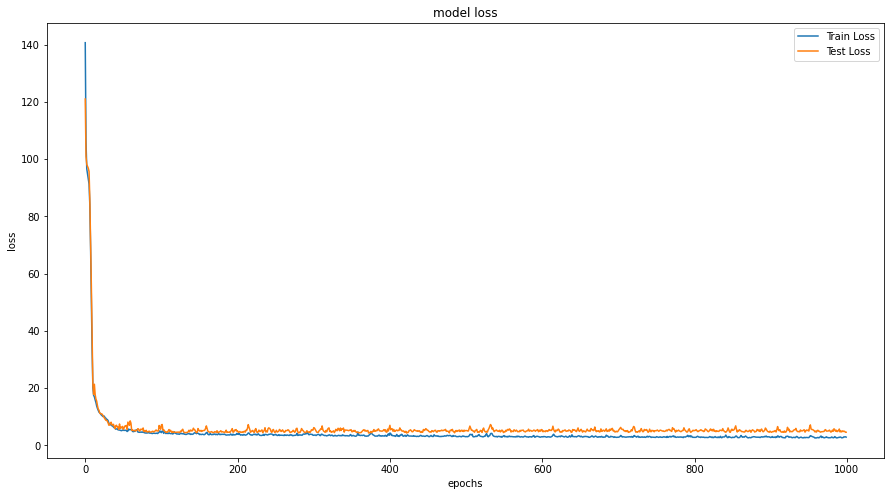

In [117]:
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

# invert predictions
train_predict = scaler.inverse_transform(train_predict)
trainY = scaler.inverse_transform(trainY)
test_predict = scaler.inverse_transform(test_predict)
testY = scaler.inverse_transform(testY)
print('Train MAPE : %.2f ' % (train_score[1]))
print('Test MAPE : %.2f ' % (test_score[1]))
model_loss(model_history)

In [118]:
import seaborn as sns

In [119]:
def prediction_plot(testY, test_predict,look_back):
    len_prediction=[x for x in range(298,333)]
    plt.plot(trainY.reshape(-1,))
    plt.plot(len_prediction, testY.reshape(-1,), marker='.', label='actual')
    plt.plot(len_prediction, test_predict, 'g', label="prediction")
    plt.tight_layout()
    sns.despine(top=True)
    plt.subplots_adjust(left=0.07)
    plt.ylabel('Units', size=15)
    plt.xlabel('Time step', size=15)
    plt.legend(fontsize=15)
    plt.show()

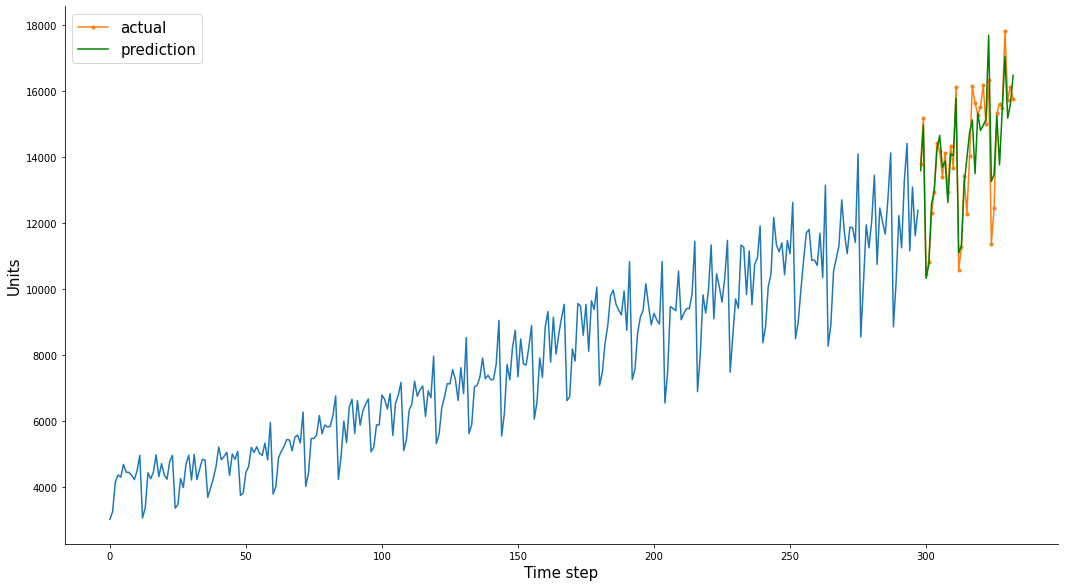

In [120]:
test_predict = model.predict(testX)
test_predict = scaler.inverse_transform(test_predict)
prediction_plot(testY, test_predict,look_back)